In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

Set Computational Device

In [19]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


Data Preprocessing

In [3]:
dataset = pd.read_csv('../data/SN_m_tot_V2.0.csv', delimiter=';', names=['Year', 'Month', 'Spaced Time','Sunspots','a','b','c'])

In [4]:
dataset.head()

,Year,Month,Spaced Time,Sunspots,a,b,c
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         3277 non-null   int64  
 1   Month        3277 non-null   int64  
 2   Spaced Time  3277 non-null   float64
 3   Sunspots     3277 non-null   float64
 4   a            3277 non-null   float64
 5   b            3277 non-null   int64  
 6   c            3277 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.3 KB


In [6]:
dataset.columns

Index(['Year', 'Month', 'Spaced Time', 'Sunspots', 'a', 'b', 'c'], dtype='object')

In [8]:

# time = dataset.drop(['Year','Month','Sunspots','a','b','c'],axis=1)
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(Day=1))
data = dataset.drop(['Year','Month','Spaced Time','a','b','c'],axis=1)
data = data.set_index('Date')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3277 entries, 1749-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3277 non-null   float64
dtypes: float64(1)
memory usage: 51.2 KB


In [14]:
#time.info()

Data Visualisation - Plot Data

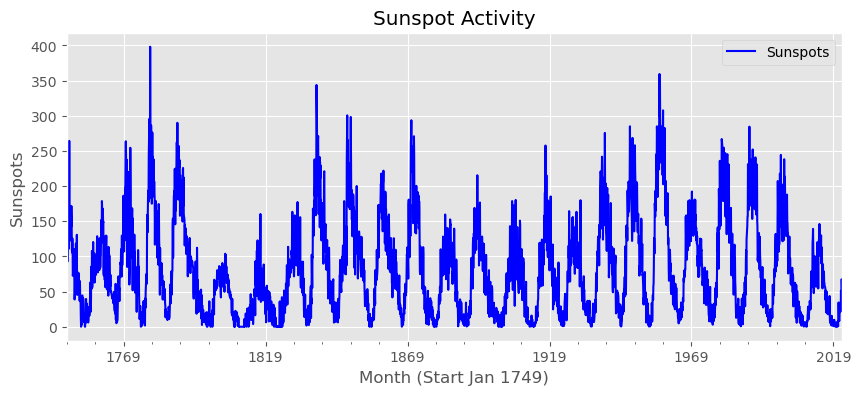

In [10]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

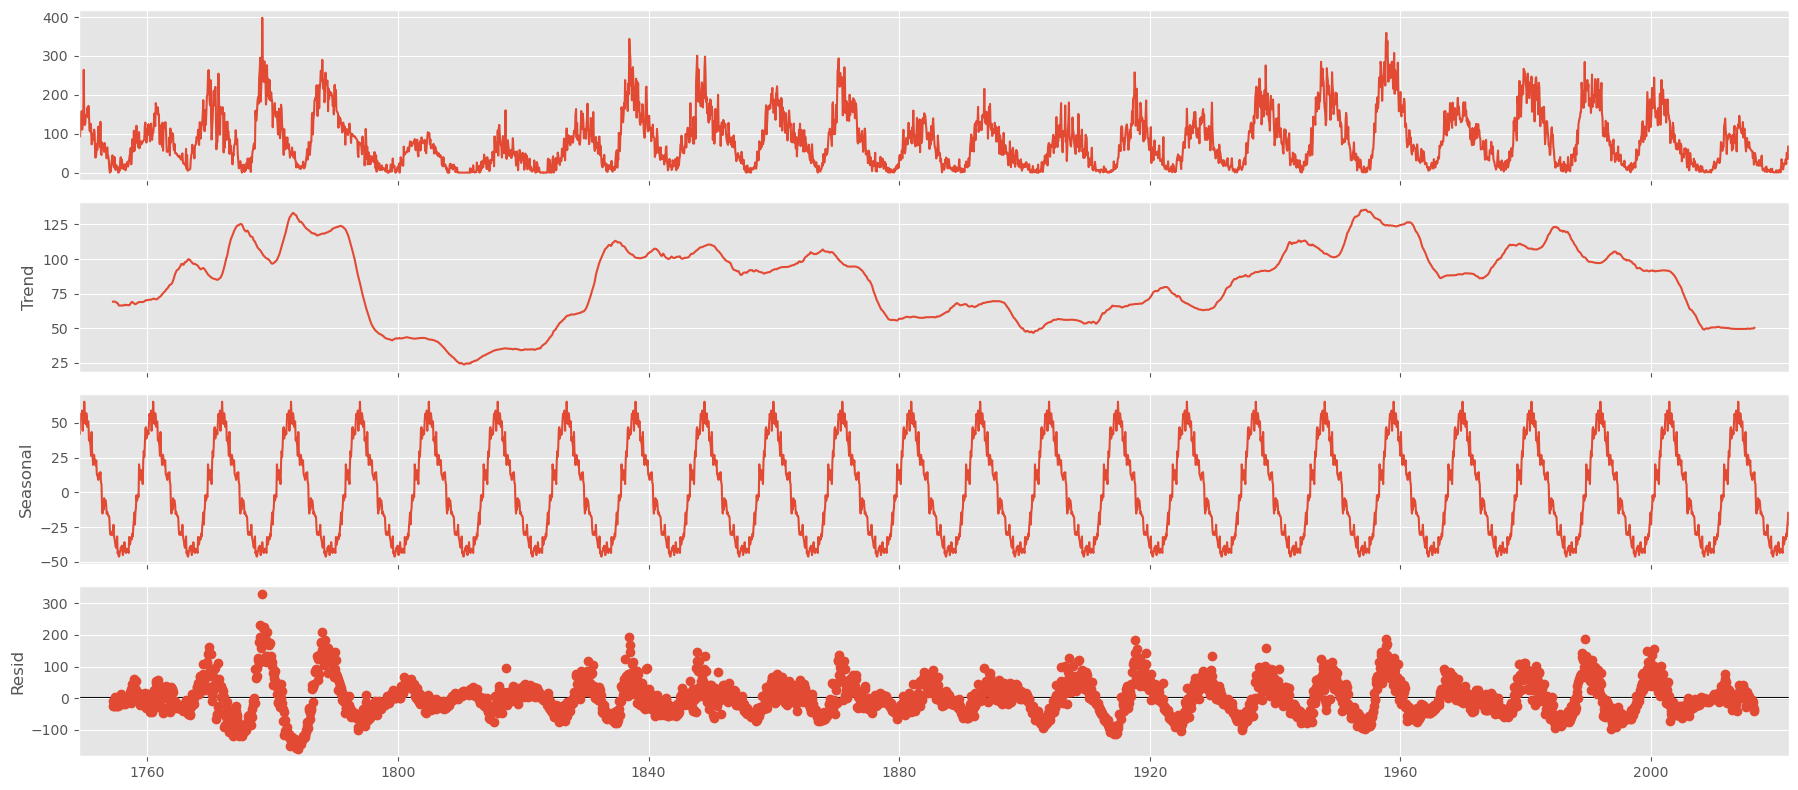

In [12]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 132)
fig = decomposition.plot()
plt.show()

Normalize Data

In [15]:
data_raw = data.to_numpy()

In [16]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
#scaler = QuantileTransformer(output_distribution='uniform')
# scaler = PowerTransformer()
scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data_raw)

Plot Normalized Data

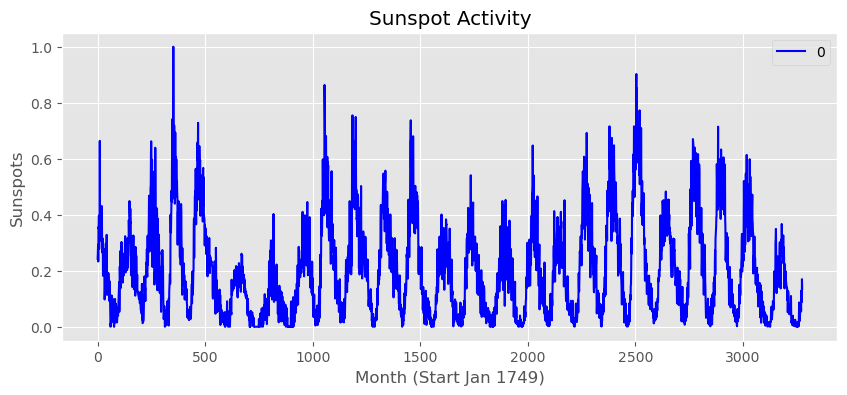

In [17]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

In [18]:
data_scaled.shape

(3277, 1)

In [21]:
# Split data using 2 seasonal cycles of data to predict
seasonal_length = 132
cycles_to_predict = 2

# Calculate train/test split
split = len(data) - (cycles_to_predict * seasonal_length )

# Length of data to train with
n_input = len(data) - split

# Target sequence values used to calculate performance metrics 
data_targets = data.to_numpy()[split:]

# Create train and test data sets
train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)


(3013, 1)
(264, 1)


In [22]:
print(split)

3013


Convert to sequences

In [23]:
# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

/var/folders/y7/nfq0trys2_x8ytsn7c7gzrdr0000gn/T/ipykernel_97488/983403349.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)


## Training Set-up (Shared Across Models)

In [44]:
# Parameters
n_features = 1
batch_size = 20
epochs = 100
n_runs = 3

### Dataset and DataLoader

In [45]:

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

### Train Model Function

In [46]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

### Performance Evaluation Function

In [43]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

## Vanilla LSTM

### Define LSTM model

In [27]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Vanilla LSTM Training

In [47]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/100], Loss: 0.0116
Epoch [50/100], Loss: 0.0101
Epoch [75/100], Loss: 0.0099
Epoch [100/100], Loss: 0.0098
Epoch [25/100], Loss: 0.0124
Epoch [50/100], Loss: 0.0084
Epoch [75/100], Loss: 0.0085
Epoch [100/100], Loss: 0.0084
Epoch [25/100], Loss: 0.0114
Epoch [50/100], Loss: 0.0087
Epoch [75/100], Loss: 0.0104
Epoch [100/100], Loss: 0.0101


### Vanilla LSTM predictions

In [48]:
print(final_vanilla.shape)
print(final_vanilla)

(264,)
[144.67770008 155.01057262 155.4753667  151.86423897 149.99976986
 152.38694144 155.55179201 150.26440635 147.64108372 150.99393977
 149.12677283 142.58877314 140.72990539 142.89740166 140.34414348
 138.87510812 135.23753216 134.48034006 130.43701769 126.09422834
 125.46847036 122.40619664 114.81663685 114.31707163 115.50674715
 112.67954852 108.36116226 108.12303333 108.81389918 108.15458844
 101.67730178 101.16827438  96.66665329  93.17711973  91.31606642
  91.16404651  84.92732553  80.36399456  85.78943037  78.95354799
  77.39307718  77.39094898  71.42299431  70.02208113  65.50314567
  67.17244937  64.40384348  61.38161986  57.7292731   53.15879209
  50.18130418  50.59804169  47.11441706  46.24076436  47.28070244
  44.64391142  40.48337687  39.27211476  34.07008949  32.73854948
  34.37760149  28.58592051  30.42069075  26.9109309   21.85011939
  21.66290803  21.742941    17.57152612  21.66406608  21.14508203
  16.59553046  13.94868291  13.46522654  13.97582487  12.40099465
  1

### Vanilla LSTM Prediction Visualization

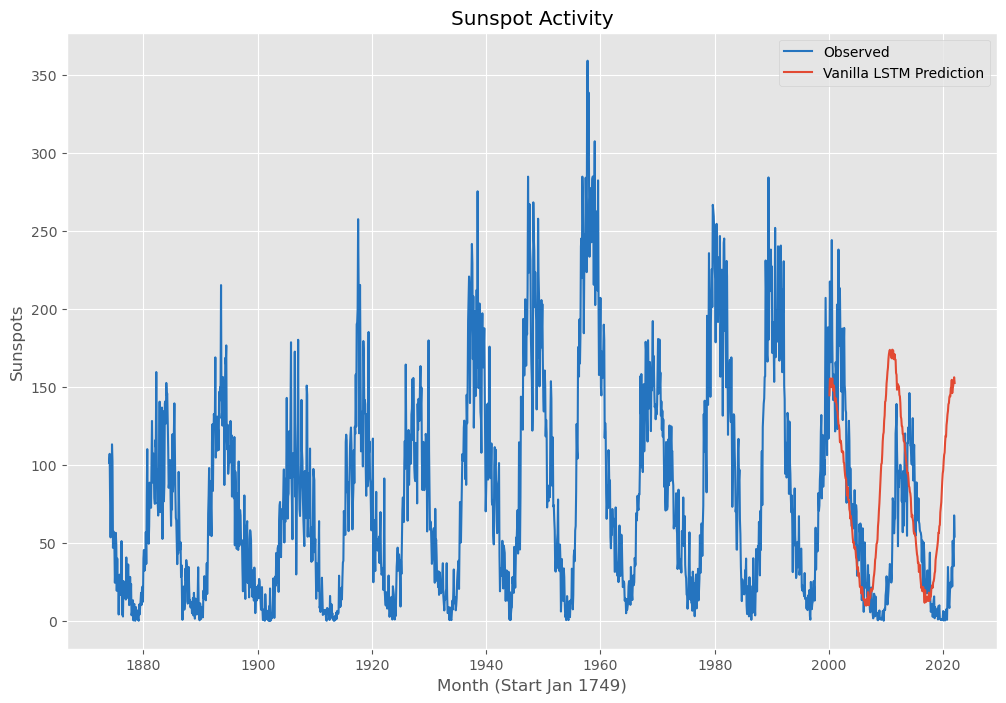

In [49]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

### Vanilla LSTM Perfomance Metrics

In [50]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': np.float64(6517.16),
 'RMSE': np.float64(80.73),
 'MAPE': np.float64(32982.91)}

## Stacked LSTM


### Define Stacked LSTM model

In [51]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Stacked LSTM Training

In [56]:
# Train and predict multiple times
store2 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)
            
 # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)

Epoch [25/100], Loss: 0.0120
Epoch [50/100], Loss: 0.0137
Epoch [75/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0133
Epoch [25/100], Loss: 0.0105
Epoch [50/100], Loss: 0.0108
Epoch [75/100], Loss: 0.0093
Epoch [100/100], Loss: 0.0099
Epoch [25/100], Loss: 0.0137
Epoch [50/100], Loss: 0.0128
Epoch [75/100], Loss: 0.0122
Epoch [100/100], Loss: 0.0137


### Stacked LSTM Predictions

In [57]:
print(final_stacked)
print(final_stacked.shape)

[155.8339288  164.03021539 169.57145414 167.73529641 166.46328567
 166.9690377  166.94177855 163.72847781 165.41266308 163.02245348
 159.59155816 157.95617511 151.33890987 154.83245655 149.95124848
 146.89657774 143.0340218  139.18032281 138.33843785 130.3162918
 128.60203482 126.15152359 119.35050531 117.83432518 112.13843989
 114.00604197 108.78136699 105.96273061 102.23941946  99.61987457
  96.34564323  93.89969299  92.2562303   86.4042645   83.78537232
  82.27586161  77.09835712  73.28258202  74.28596292  68.82883553
  66.38737805  60.57530017  58.56605908  55.22563302  54.95558306
  49.64813477  50.42286969  45.51736732  41.41157754  41.70142212
  35.95496044  36.21655297  34.06503798  30.85199634  28.46708201
  27.02022018  25.31814201  23.06185768  23.1151764   22.40015469
  20.07521416  18.78731214  20.85157193  17.90369389  16.75557068
  17.86704574  15.95181432  14.28034385  13.17698305  12.25072762
  12.5871246   12.19759383  12.98242583  10.46416427  14.82898029
  13.163120

### Stacked LSTM Prediction Visualisation

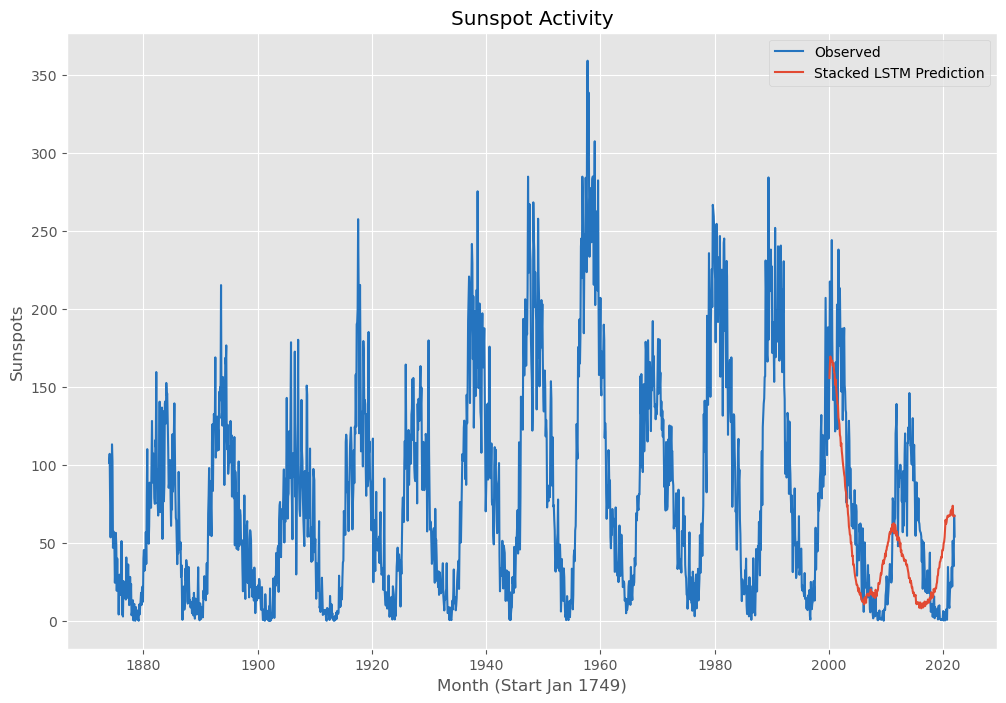

In [58]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [59]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': np.float64(5020.86),
 'RMSE': np.float64(70.86),
 'MAPE': np.float64(18698.29)}